# Data Generation Post-processing

In [1]:
from matplotlib import offsetbox
from collections import defaultdict
from scipy.stats import spearmanr
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import os
from utils_pp_standalone import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.manifold import Isomap
from sklearn.decomposition import PCA, KernelPCA
#import seaborn as sns
from scipy.stats import pointbiserialr
from collections import defaultdict
import re

In [2]:
plt.rcParams.update({"figure.figsize": [8, 4],
                     "text.usetex": True,
                     "font.family": "serif",
                     "font.serif": "Computer Modern",
                     "axes.labelsize": 20,
                     "axes.titlesize": 20,
                     'figure.titlesize': 20,
                     "legend.fontsize": 20,
                     "xtick.labelsize": 16,
                     "ytick.labelsize": 16,
                     "savefig.dpi": 130,
                    'legend.fontsize': 20,
                     'legend.handlelength': 2,
                     'legend.loc': 'upper right'})

## Data description

In [3]:
path = '../results/MareNostrum'

dir_name = 'datagen_ACOPF_slurm23172357_cu10_nodes32_LF09_seed3_nc3_ns500_d7_20250627_214226_7664-20250630T085420Z-1-005'

path_results = os.path.join(path, dir_name)

results_dataframes, csv_files = open_csv(path_results, ['cases_df.csv', 'case_df_op.csv'])

In [4]:
columns_in_df = dict()
for key, item in results_dataframes.items():
    columns_in_df[key] = list(results_dataframes[key].columns)

In [5]:
def print_columns_groups(key, columns_list):
    # Group columns by the alphabetic prefix
    groups = defaultdict(list)
    for col in columns_list:
        match = re.match(r"([A-Za-z_]+)", col)  # extract the prefix before any digit
        prefix = match.group(1) if match else col
        groups[prefix].append(col)
    
    print(key+':\n')

    # Print grouped columns
    for prefix, cols in groups.items():
        print(f"{prefix}: {cols[0]},...,{cols[-1]}; N. elements: {len(cols)}\n")
        
for key, item in columns_in_df.items():
    print_columns_groups(key, item)

cases_df:

p_sg_Var: p_sg_Var0,...,p_sg_Var52; N. elements: 53

q_sg_Var: q_sg_Var0,...,q_sg_Var52; N. elements: 53

p_cig_Var: p_cig_Var0,...,p_cig_Var52; N. elements: 53

p_g_for_Var: p_g_for_Var0,...,p_g_for_Var52; N. elements: 53

p_g_fol_Var: p_g_fol_Var0,...,p_g_fol_Var52; N. elements: 53

q_cig_Var: q_cig_Var0,...,q_cig_Var52; N. elements: 53

q_g_for_Var: q_g_for_Var0,...,q_g_for_Var52; N. elements: 53

q_g_fol_Var: q_g_fol_Var0,...,q_g_fol_Var52; N. elements: 53

perc_g_for_Var: perc_g_for_Var0,...,perc_g_for_Var0; N. elements: 1

tau_droop_f_gfor_: tau_droop_f_gfor_12,...,tau_droop_f_gfor_82; N. elements: 53

tau_droop_u_gfor_: tau_droop_u_gfor_12,...,tau_droop_u_gfor_82; N. elements: 53

tau_droop_f_gfol_: tau_droop_f_gfol_12,...,tau_droop_f_gfol_82; N. elements: 53

tau_droop_u_gfol_: tau_droop_u_gfol_12,...,tau_droop_u_gfol_82; N. elements: 53

p_load_Var: p_load_Var0,...,p_load_Var90; N. elements: 91

q_load_Var: q_load_Var0,...,q_load_Var90; N. elements: 91

case_id: cas

### General Description

- cases_df: sampled quantities

    - p_X_Var, q_X_Var: N. elements: 53, P and Q in each generation unit from each typer of element (X = [sg, cig, g_for, g_fol]) (=0 where the element is not present) [MW, Mvar]

    - perc_g_for_Var: N. elements: 1

    - tau_droop_f_X_,tau_droop_u_X_ : N. elements: 53, taus de cada convertidor (X = [gfor, gfol])

    - p_load_Var, q_load_Var: N. elements: 91, P and Q of each load [MW, Mvar]

    - case_id: N. elements: 1

    - Stability: N. elements: 1 =1: stable, =0 unstable, = -1: unfeasible, =-2 feasible but to a point out of the sampling cell
 
- case_df_op: after power flow quantities

    - V, theta:  N. elements: 118
    - P_SG, Q_SG, Sn_SG: N. elements: 47, P and Q injected by SG in p.u. and installed capacity in MVA (of the SGs effectively present in the grid)
    - P_X, Q_X, Sn_X: N. elements: 18, P and Q injected by X in p.u. and installed capacity in MVA. X is GFOL or GFOR, if the converter is not included in the grid there is a NaN value.

    - PL, QL: N. elements: 91  P and Q of each load p.u.

    - case_id: case_id,...,case_id; N. elements: 1

    - Stability: N. elements: 1 =1: stable, =0 unstable, = -1: unfeasible, =-2 feasible but to a point out of the sampling cell


In [6]:
# %% ---- FILL NAN VALUES WITH NULL ---

results_dataframes['case_df_op'] = results_dataframes['case_df_op'].fillna(0)

# %% ---- FIX VALUES ----

Sn_cols = [col for col in results_dataframes['case_df_op']
           if col.startswith('Sn')]
results_dataframes['case_df_op'][Sn_cols] = results_dataframes['case_df_op'][Sn_cols]/100 #p.u. system base 100 MVA

theta_cols = [col for col in results_dataframes['case_df_op']
              if col.startswith('theta')]
# Adjust angles greater than 180°
results_dataframes['case_df_op'][theta_cols] = results_dataframes['case_df_op'][theta_cols] - \
    (results_dataframes['case_df_op'][theta_cols] > 180) * 360

results_dataframes['case_df_op'][theta_cols] = results_dataframes['case_df_op'][theta_cols] * np.pi/180

# add total demand variables
PL_cols = [
    col for col in results_dataframes['case_df_op'].columns if col.startswith('PL')]
results_dataframes['case_df_op']['PD'] = results_dataframes['case_df_op'][PL_cols].sum(
    axis=1)

QL_cols = [
    col for col in results_dataframes['case_df_op'].columns if col.startswith('QL')]
results_dataframes['case_df_op']['QD'] = results_dataframes['case_df_op'][QL_cols].sum(
    axis=1)


C:\Users\Francesca\AppData\Local\Temp\ipykernel_11604\3565725333.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_dataframes['case_df_op']['PD'] = results_dataframes['case_df_op'][PL_cols].sum(
C:\Users\Francesca\AppData\Local\Temp\ipykernel_11604\3565725333.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  results_dataframes['case_df_op']['QD'] = results_dataframes['case_df_op'][QL_cols].sum(


### Data Set Composition

In [7]:
perc_stability(results_dataframes['case_df_op'], dir_name)

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
datagen_ACOPF_slurm23172357_cu10_nodes32_LF09_seed3_nc3_ns500_d7_20250627_214226_7664-20250630T085420Z-1-005
$|\mathcal{D}|$: 127500
Feasible cases: 4.48156862745098%
Stable cases: 1.9843137254901961% of total cases
Stable cases: 44.27721386069303% of feasible cases
Unfeasible cases: 35.26352941176471%
Out of cell cases: 60.25490196078431%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


In [8]:
# %% ---- SELECT ONLY FEASIBLE CASES ----
# from data frame with power flow results: case_df_op
results_dataframes['case_df_op_feasible'] = results_dataframes['case_df_op'].query(
    'Stability >= 0')

# from data frame with sampled quantities: cases_df
results_dataframes['cases_df_feasible'] = results_dataframes['cases_df'].query(
    'Stability >= 0')
case_id_feasible = list(results_dataframes['case_df_op_feasible']['case_id'])

# %% ---- SELECT ONLY UNFEASIBLE CASES (from data frame with sampled quantities: cases_df)----

results_dataframes['cases_df_unfeasible'] = results_dataframes['cases_df'].query('Stability < 0')
results_dataframes['cases_df_unfeasible_1'] = results_dataframes['cases_df'].query('Stability == -1')
results_dataframes['cases_df_unfeasible_2'] = results_dataframes['cases_df'].query('Stability == -2')

case_id_Unfeasible = list(results_dataframes['cases_df_unfeasible']['case_id'])
case_id_Unfeasible1 = list(results_dataframes['cases_df_unfeasible_1']['case_id'])
case_id_Unfeasible2 = list(results_dataframes['cases_df_unfeasible_2']['case_id'])

In [9]:
def create_dimensions_caseid_df(df_dict, df_name, vars_dim1, vars_dim2, name_dim1, name_dim2):
    dimensions_caseid = pd.DataFrame(columns = [name_dim1,name_dim2,'case_id','Stability'])
    dimensions_caseid[name_dim1] =  df_dict[df_name][vars_dim1].sum(axis=1)
    dimensions_caseid[name_dim2] =  df_dict[df_name][vars_dim2].sum(axis=1)
    dimensions_caseid['case_id'] =  df_dict[df_name]['case_id']
    dimensions_caseid['Stability'] = list(df_dict[df_name]['Stability'])

    return dimensions_caseid

p_sg_var=[var for var in results_dataframes['case_df_op_feasible'].columns if var.startswith('P_SG')]
p_cig_var=[var for var in results_dataframes['case_df_op_feasible'].columns if var.startswith('P_GFOR') or var.startswith('P_GFOL')]

dimensions_caseid_feasible = create_dimensions_caseid_df(results_dataframes, 'case_df_op_feasible', p_sg_var, p_cig_var, 'p_sg', 'p_cig')
dimensions_caseid_feasible['p_sg'] = dimensions_caseid_feasible['p_sg']*100
dimensions_caseid_feasible['p_cig'] = dimensions_caseid_feasible['p_cig']*100

p_sg_var=[var for var in results_dataframes['cases_df_unfeasible'].columns if var.startswith('p_sg')]
p_cig_var=[var for var in results_dataframes['cases_df_unfeasible'].columns if var.startswith('p_cig')]

dimensions_caseid_feasible_sampled = create_dimensions_caseid_df(results_dataframes, 'cases_df_feasible', p_sg_var, p_cig_var, 'p_sg', 'p_cig')
dimensions_caseid_unfeasible = create_dimensions_caseid_df(results_dataframes, 'cases_df_unfeasible', p_sg_var, p_cig_var, 'p_sg', 'p_cig')
dimensions_caseid_unfeasible1 = create_dimensions_caseid_df(results_dataframes, 'cases_df_unfeasible_1', p_sg_var, p_cig_var, 'p_sg', 'p_cig')
dimensions_caseid_unfeasible2 = create_dimensions_caseid_df(results_dataframes, 'cases_df_unfeasible_2', p_sg_var, p_cig_var, 'p_sg', 'p_cig')

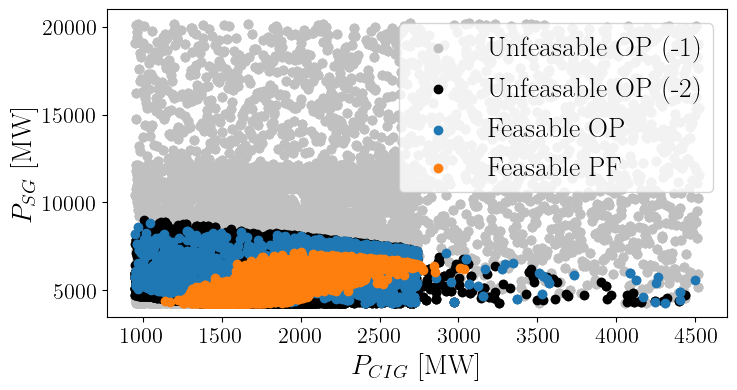

In [10]:
fig, ax = plt.subplots()
ax.scatter(dimensions_caseid_unfeasible1['p_cig'], dimensions_caseid_unfeasible1['p_sg'],color='silver', label='Unfeasable OP (-1)')
ax.scatter(dimensions_caseid_unfeasible2['p_cig'], dimensions_caseid_unfeasible2['p_sg'],color='k', label='Unfeasable OP (-2)')
ax.scatter(dimensions_caseid_feasible_sampled['p_cig'], dimensions_caseid_feasible_sampled['p_sg'], label='Feasable OP')
ax.scatter(dimensions_caseid_feasible['p_cig'], dimensions_caseid_feasible['p_sg'], label='Feasable PF')
ax.set_xlabel('$P_{CIG}$ [MW]')
ax.set_ylabel('$P_{SG}$ [MW]')
plt.legend()

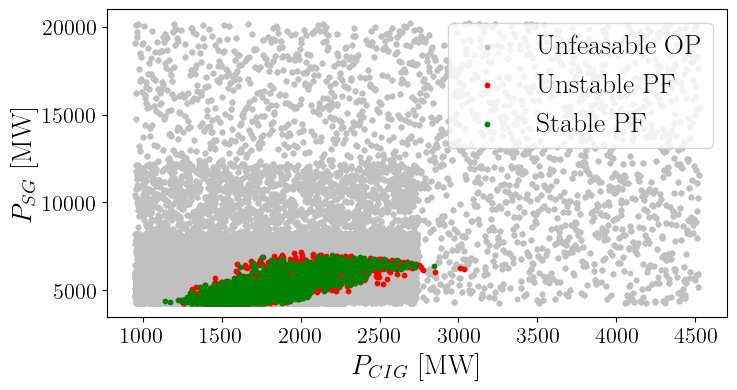

In [34]:
fig, ax = plt.subplots()
ax.scatter(dimensions_caseid_unfeasible['p_cig'], dimensions_caseid_unfeasible['p_sg'],color='silver', label='Unfeasable OP', s=10)
ax.scatter(dimensions_caseid_feasible.query('Stability ==0')['p_cig'], dimensions_caseid_feasible.query('Stability ==0')['p_sg'], color='r',label='Unstable PF', s=10)
ax.scatter(dimensions_caseid_feasible.query('Stability ==1')['p_cig'], dimensions_caseid_feasible.query('Stability ==1')['p_sg'], color='g', label='Stable PF', s=10)
ax.set_xlabel('$P_{CIG}$ [MW]')
ax.set_ylabel('$P_{SG}$ [MW]')
plt.legend()

Mesh obtained from parsing the logs file of the data generator process: the mesh shows the cell splitting process. It is obtained from the parsing_dimensions.py code.

Plot the mesh on top of the OPs scatter plot.

In [12]:
mesh_df = pd.read_excel('mesh.xlsx')

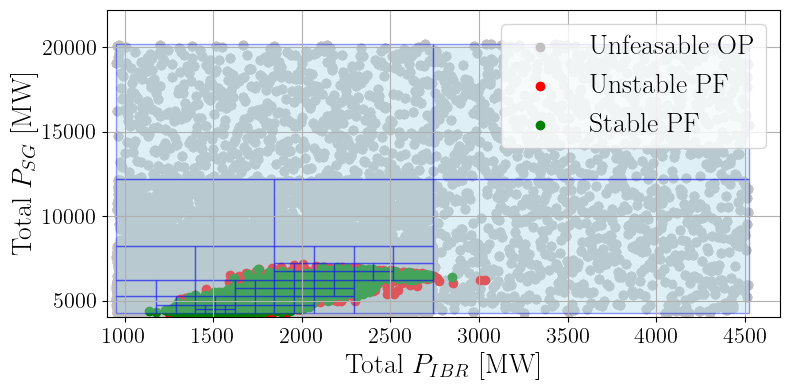

In [13]:
fig, ax = plt.subplots()
ax.scatter(dimensions_caseid_unfeasible['p_cig'], dimensions_caseid_unfeasible['p_sg'],color='silver', label='Unfeasable OP', s=10)
ax.scatter(dimensions_caseid_feasible.query('Stability ==0')['p_cig'], dimensions_caseid_feasible.query('Stability ==0')['p_sg'], color='r',label='Unstable PF', s=10)
ax.scatter(dimensions_caseid_feasible.query('Stability ==1')['p_cig'], dimensions_caseid_feasible.query('Stability ==1')['p_sg'], color='g', label='Stable PF', s=10)
ax.set_xlabel('$P_{CIG}$ [MW]')
ax.set_ylabel('$P_{SG}$ [MW]')
plot_mesh(mesh_df, ax)
plt.legend()

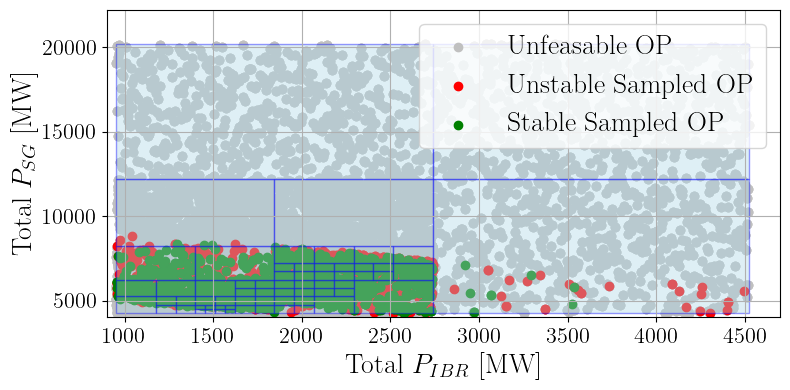

In [14]:
fig, ax = plt.subplots()
ax.scatter(dimensions_caseid_unfeasible['p_cig'], dimensions_caseid_unfeasible['p_sg'],color='silver', label='Unfeasable OP')
ax.scatter(dimensions_caseid_feasible_sampled.query('Stability ==0')['p_cig'], dimensions_caseid_feasible_sampled.query('Stability ==0')['p_sg'], color='r',label='Unstable Sampled OP')
ax.scatter(dimensions_caseid_feasible_sampled.query('Stability ==1')['p_cig'], dimensions_caseid_feasible_sampled.query('Stability ==1')['p_sg'], color='g', label='Stable Sampled OP')
ax.set_xlabel('$P_{CIG}$ [MW]')
ax.set_ylabel('$P_{SG}$ [MW]')
plot_mesh(mesh_df, ax)
plt.legend()

Dataframes with the cases_id, the exploration depth at which they have been evaluated and the corresponding cell name (as in the cell_info.csv file).
It is obtained from the parsing_dimensions.py code.

In [15]:
df_depth = pd.read_excel('cases_id_depth.xlsx')
df_depth


,Unnamed: 0,Depth,case_id,CellName
0,0,0,999dce69-594a-4e65-8b4c-912ede7a30dc,0
1,1,0,e4d50c96-a464-4072-8cf8-f07b3312d9ee,0
2,2,0,0d3bc8fd-3cb0-41cc-a444-a608a227a129,0
3,3,0,f1f6fa43-11ee-4fc0-a62b-ae6d8ec2e57b,0
4,4,0,0e42731f-8ba2-45a8-9c1b-80a2a0e91344,0
...,...,...,...,...
127495,127495,6,48c29445-7a45-45a8-a7f5-49b2804ae272,0.1.1.2.1.2.2
127496,127496,6,22917c9f-ffad-416b-b7e3-eed160aa575f,0.1.1.2.1.2.2
127497,127497,6,f527cea8-e045-4d3a-b9e2-41a5a1e91463,0.1.1.2.1.2.2
127498,127498,6,ca92d917-6610-4326-8597-1eb7ffafe426,0.1.1.2.1.2.2


In [16]:
df_feasibility_balancing = pd.DataFrame(columns=['depth','feasibility','cumulative_feasibility','feasiblity_no_2','balance','cumulative_balancing'])
cum_case_id_depth=[]
for idx, depth in enumerate(df_depth['Depth'].unique()):
    df_feasibility_balancing.loc[idx, 'depth']=depth
    case_id_depth = df_depth.query('Depth == @depth')['case_id']
    cum_case_id_depth.extend(case_id_depth)
    feas_case_id_depth = list(set(case_id_depth) & set(case_id_feasible))
    cum_feas_case_id_depth = list(set(cum_case_id_depth) & set(case_id_feasible))
    
    df_feasibility_balancing.loc[idx, 'feasibility']= len(feas_case_id_depth)/len(case_id_depth) 
    df_feasibility_balancing.loc[idx, 'cumulative_feasibility']= len(cum_feas_case_id_depth)/len(cum_case_id_depth) 

    feas_stab_depth = len(results_dataframes['cases_df_feasible'].query('case_id == @feas_case_id_depth and Stability ==1'))
    cum_feas_stab_case_id_depth = len(results_dataframes['cases_df_feasible'].query('case_id == @cum_feas_case_id_depth and Stability ==1'))
    
    df_feasibility_balancing.loc[idx, 'balance']= feas_stab_depth/len(feas_case_id_depth) 
    df_feasibility_balancing.loc[idx, 'cumulative_balancing']= cum_feas_stab_case_id_depth/len(cum_feas_case_id_depth) 
    

In [17]:
df_feasibility_balancing

,depth,feasibility,cumulative_feasibility,feasiblity_no_2,balance,cumulative_balancing
0,0,0.012,0.012,NaN,0.388889,0.388889
1,1,0.014667,0.014133,NaN,0.329545,0.339623
2,2,0.042,0.026519,NaN,0.396825,0.379888
3,3,0.071833,0.047843,NaN,0.403712,0.396721
4,4,0.054667,0.051532,NaN,0.42378,0.412238
5,5,0.0455,0.048398,NaN,0.464835,0.437925
6,6,0.010333,0.044816,NaN,0.66129,0.442772


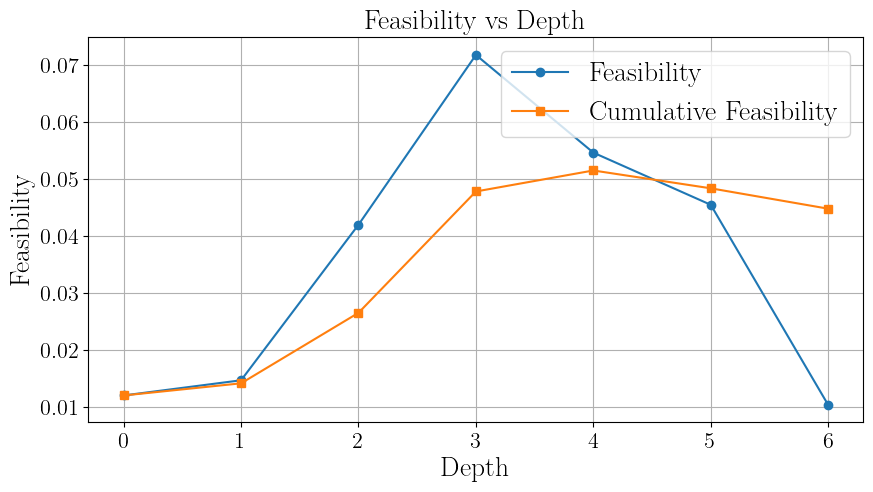

In [18]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is called df
# Plot 1: Feasibility
plt.figure(figsize=(10, 5))
plt.plot(df_feasibility_balancing['depth'], df_feasibility_balancing['feasibility'], marker='o', label='Feasibility')
plt.plot(df_feasibility_balancing['depth'], df_feasibility_balancing['cumulative_feasibility'], marker='s', label='Cumulative Feasibility')
plt.xlabel('Depth')
plt.ylabel('Feasibility')
plt.title('Feasibility vs Depth')
plt.grid(True)
plt.legend()
plt.show()


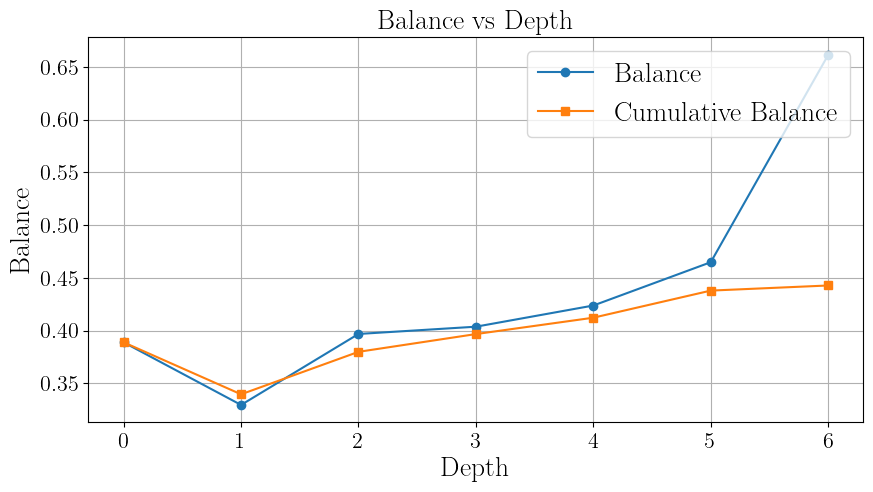

In [19]:
# Plot 2: Balancing
plt.figure(figsize=(10, 5))
plt.plot(df_feasibility_balancing['depth'], df_feasibility_balancing['balance'], marker='o', label='Balance')
plt.plot(df_feasibility_balancing['depth'], df_feasibility_balancing['cumulative_balancing'], marker='s', label='Cumulative Balance')
plt.xlabel('Depth')
plt.ylabel('Balance')
plt.title('Balance vs Depth')
plt.grid(True)
plt.legend()
plt.show()


## Training Stability Assessment Models
### Data Cleaning

In [20]:
columns_in_df = dict()
for key, item in results_dataframes.items():
    columns_in_df[key] = results_dataframes[key].columns

In [21]:
# %% ----  Remove columns with only 1 value ----
columns_with_single_values = []
for c in columns_in_df['case_df_op_feasible']:
    if results_dataframes['case_df_op_feasible'][c].unique().size == 1:
        columns_with_single_values.append(c)
# --> if there is something different from Sn_SGX check, otherwise it is normal (no changes in SG installed power)
print(columns_with_single_values)

results_dataframes['case_df_op_feasible'] = results_dataframes['case_df_op_feasible'].drop(
    columns_with_single_values, axis=1)

['Sn_SG12', 'Sn_SG103', 'Sn_SG34', 'Sn_SG74', 'Sn_SG112', 'Sn_SG107', 'Sn_SG36', 'Sn_SG66', 'Sn_SG46', 'Sn_SG49', 'Sn_SG25', 'Sn_SG113', 'Sn_SG26', 'Sn_SG10', 'Sn_SG4', 'Sn_SG100', 'Sn_SG89', 'Sn_SG90', 'Sn_SG87', 'Sn_SG65', 'Sn_SG18', 'Sn_SG6', 'Sn_SG8', 'Sn_SG85', 'Sn_SG91', 'Sn_SG40', 'Sn_SG62', 'Sn_SG55', 'Sn_SG111', 'Sn_SG42', 'Sn_SG54', 'Sn_SG56', 'Sn_SG76', 'Sn_SG59', 'Sn_SG61', 'Sn_SG77', 'Sn_SG99', 'Sn_SG80', 'Sn_SG32', 'Sn_SG116', 'Sn_SG69', 'Sn_SG92', 'Sn_SG105', 'Sn_SG19', 'Sn_SG70', 'Sn_SG72', 'Sn_SG24']


In [22]:
# Create dataframe with only input quantities
results_dataframes['case_df_op_feasible_X'] = results_dataframes['case_df_op_feasible'].drop(['case_id', 'Stability'], axis=1)

In [23]:
# %% ---- Check correlated variables Option #1 ----
def get_correlated_columns(df, c_threshold=0.95, method='pearson'):

    correlated_features_tuples = []
    correlated_features = pd.DataFrame(columns=['Feat1', 'Feat2', 'Corr'])
    correlation = df.corr(method=method)
    count = 0
    for i in correlation.index:
        for j in correlation:
            if i != j and abs(correlation.loc[i, j]) >= c_threshold:
                # if tuple([j,i]) not in correlated_features_tuples:
                correlated_features_tuples.append(tuple([i, j]))
                correlated_features.loc[count, 'Feat1'] = i
                correlated_features.loc[count, 'Feat2'] = j
                correlated_features.loc[count, 'Corr'] = correlation.loc[i, j]
                count = count+1

    return correlated_features


correlated_features = get_correlated_columns(
    results_dataframes['case_df_op_feasible_X'])

grouped_corr_feat = correlated_features.groupby('Feat1').count().reset_index()

keep_var=[]
while not grouped_corr_feat.empty:
    # Pick the first remaining Feat1
    var = grouped_corr_feat.iloc[0]['Feat1']
    keep_var.append(var)

    # Find all features correlated with this one
    to_remove = correlated_features.query('Feat1 == @var')['Feat2'].tolist()

    # Drop all rows where Feat1 is in to_remove
    grouped_corr_feat = grouped_corr_feat[~grouped_corr_feat['Feat1'].isin(to_remove)]
    grouped_corr_feat = grouped_corr_feat[~grouped_corr_feat['Feat1'].isin(keep_var)]

df_taus = results_dataframes['case_df_op_feasible'][['case_id']].merge(results_dataframes['cases_df_feasible'][[
                                                                       col for col in columns_in_df['cases_df_feasible'] if col.startswith('tau_droop')]+['case_id']], on='case_id', how='left').drop(['case_id'], axis=1)

results_dataframes['case_df_op_feasible_uncorr_X'] = pd.concat([results_dataframes['case_df_op_feasible_X'][keep_var].reset_index(drop=True), df_taus],axis=1)
results_dataframes['case_df_op_feasible_uncorr'] = results_dataframes['case_df_op_feasible_uncorr_X']
results_dataframes['case_df_op_feasible_uncorr']['case_id'] = results_dataframes['case_df_op_feasible']['case_id'].reset_index(drop=True)
results_dataframes['case_df_op_feasible_uncorr']['Stability'] = results_dataframes['case_df_op_feasible']['Stability'].reset_index(drop=True)

results_dataframes['case_df_op_feasible_uncorr'].to_csv('DataSet_training_uncorr_var.csv')

In [24]:
print_columns_groups('case_df_op_feasible_uncorr', results_dataframes['case_df_op_feasible_uncorr'].columns)

case_df_op_feasible_uncorr:

PD: PD,...,PD; N. elements: 1

P_GFOL: P_GFOL104,...,P_GFOL92; N. elements: 11

P_GFOR: P_GFOR104,...,P_GFOR92; N. elements: 9

P_SG: P_SG113,...,P_SG92; N. elements: 6

Q_SG: Q_SG6,...,Q_SG6; N. elements: 1

Sn_GFOL: Sn_GFOL100,...,Sn_GFOL92; N. elements: 14

V: V1,...,V99; N. elements: 25

theta: theta1,...,theta24; N. elements: 6

tau_droop_f_gfor_: tau_droop_f_gfor_12,...,tau_droop_f_gfor_82; N. elements: 53

tau_droop_u_gfor_: tau_droop_u_gfor_12,...,tau_droop_u_gfor_82; N. elements: 53

tau_droop_f_gfol_: tau_droop_f_gfol_12,...,tau_droop_f_gfol_82; N. elements: 53

tau_droop_u_gfol_: tau_droop_u_gfol_12,...,tau_droop_u_gfol_82; N. elements: 53

case_id: case_id,...,case_id; N. elements: 1

Stability: Stability,...,Stability; N. elements: 1



In [25]:
# %% ---- Check correlated variables Option #2 ----

results = pd.concat([results_dataframes['case_df_op_feasible_X'].reset_index(drop=True), df_taus.reset_index(drop=True)], axis=1).apply(
#results = results_dataframes['case_df_op_feasible_X'].reset_index(drop=True).apply(
     lambda col: pointbiserialr(col, results_dataframes['case_df_op_feasible']['Stability']), result_type='expand').T
results.columns = ['correlation', 'p_value']
results['abs_corr'] = abs(results['correlation'])

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
X = pd.concat([results_dataframes['case_df_op_feasible_X'].reset_index(
    drop=True), df_taus.reset_index(drop=True)], axis=1)
# X = results_dataframes['case_df_op_feasible_X'].reset_index(
#     drop=True)
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
# dendro = hierarchy.dendrogram(
#     dist_linkage, labels=X.columns.to_list(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# _ = fig.tight_layout()


cluster_ids = hierarchy.fcluster(dist_linkage, 0.01, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

selected_features_names_dict = defaultdict(list)
for i, selected_features in cluster_id_to_feature_ids.items():
    selected_features_names_dict[i]=X.columns[selected_features]

keep_var = []
for i, selected_features in selected_features_names_dict.items():
    if len(selected_features)==1:
        keep_var.append(selected_features[0])
    elif len(selected_features)>1:
         keep_var.append(results.loc[selected_features,'abs_corr'].sort_values(ascending=False).index[0])

results_dataframes['case_df_op_feasible_uncorr_HierCl_X'] = X[keep_var]
results_dataframes['case_df_op_feasible_uncorr_HierCl'] = pd.concat([X[keep_var], results_dataframes['case_df_op_feasible'][['case_id', 'Stability']].reset_index(drop=True)],axis=1)

results_dataframes['case_df_op_feasible_uncorr_HierCl'].to_csv('DataSet_training_uncorr_var_HierCl.csv')

In [26]:
print_columns_groups('case_df_op_feasible_uncorr_HierCl', results_dataframes['case_df_op_feasible_uncorr_HierCl'].columns)

case_df_op_feasible_uncorr_HierCl:

V: V1,...,V118; N. elements: 87

theta: theta1,...,theta115; N. elements: 50

P_SG: P_SG12,...,P_SG24; N. elements: 42

Q_SG: Q_SG12,...,Q_SG24; N. elements: 46

P_GFOL: P_GFOL112,...,P_GFOL82; N. elements: 17

Q_GFOL: Q_GFOL112,...,Q_GFOL31; N. elements: 14

Sn_GFOL: Sn_GFOL112,...,Sn_GFOL82; N. elements: 14

Sn_GFOR: Sn_GFOR18,...,Sn_GFOR31; N. elements: 4

P_GFOR: P_GFOR112,...,P_GFOR82; N. elements: 16

Q_GFOR: Q_GFOR112,...,Q_GFOR82; N. elements: 16

QL: QL114,...,QL114; N. elements: 1

tau_droop_f_gfor_: tau_droop_f_gfor_12,...,tau_droop_f_gfor_82; N. elements: 53

tau_droop_u_gfor_: tau_droop_u_gfor_12,...,tau_droop_u_gfor_82; N. elements: 53

tau_droop_f_gfol_: tau_droop_f_gfol_12,...,tau_droop_f_gfol_82; N. elements: 53

tau_droop_u_gfol_: tau_droop_u_gfol_12,...,tau_droop_u_gfol_82; N. elements: 53

case_id: case_id,...,case_id; N. elements: 1

Stability: Stability,...,Stability; N. elements: 1



In [27]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def kfold_cv_depth(df_dict, type_corr_analysis, dimensions_caseid_feasible, cases_id_depth_feas, plot_depth_exploration=True, n_fold=5):
    df = df_dict['case_df_op_feasible_'+type_corr_analysis]
    df_training = pd.DataFrame(columns= df.columns)
    cases_id_training = []
    scores_df=pd.DataFrame(columns=['Depth','score_mean','score_std','n_training_cases','perc_stable'])

    if plot_depth_exploration:
        ax = plot_mesh(mesh_df)
    
    for depth in range(0,7):
        add_case_id = list(cases_id_depth_feas.query('Depth == @depth')['case_id'])
        cases_id_training.extend(add_case_id)
        df_training = df.query('case_id == @cases_id_training')
        scores_df.loc[depth,'n_training_cases']=len(df_training)
        scores_df.loc[depth,'perc_stable']=len(df_training.query('Stability == 1'))/len(df_training)
    
        if len(df_training)>= n_fold:
            #clf = svm.SVC(kernel='linear', C=1, random_state=42)
            #clf = MLPClassifier(random_state=1, max_iter=5000, activation='relu')
            clf = Pipeline([('scaler', StandardScaler()), ('xgb', XGBClassifier())])
            X = df_training.drop(['case_id','Stability'],axis=1).reset_index(drop=True)
            y = df_training[['Stability']].reset_index(drop=True).values.astype(int).ravel()
            scores = cross_val_score(clf, X, y, cv=n_fold, scoring='accuracy')
            
            scores_df.loc[depth,'Depth']=depth
            scores_df.loc[depth,'score_mean']=scores.mean()
            scores_df.loc[depth,'score_std']=scores.std()

            if plot_depth_exploration:
                ax.scatter(dimensions_caseid_feasible.query('case_id == @add_case_id')['p_cig'],
                       dimensions_caseid_feasible.query('case_id == @add_case_id')['p_sg'], label = 'Depth '+str(depth))
    if plot_depth_exploration:
        plt.legend()
    return scores_df
    

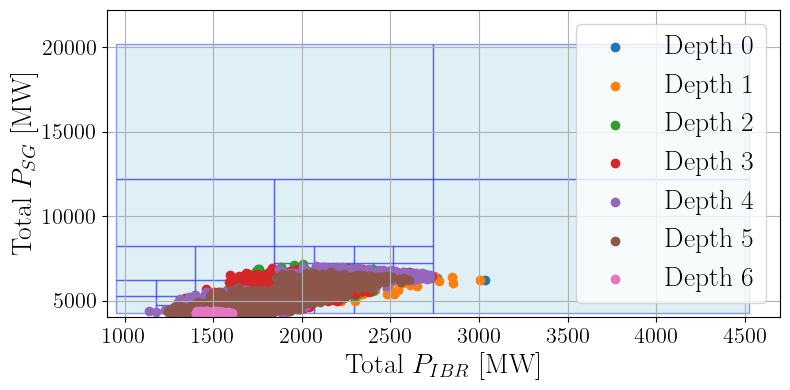

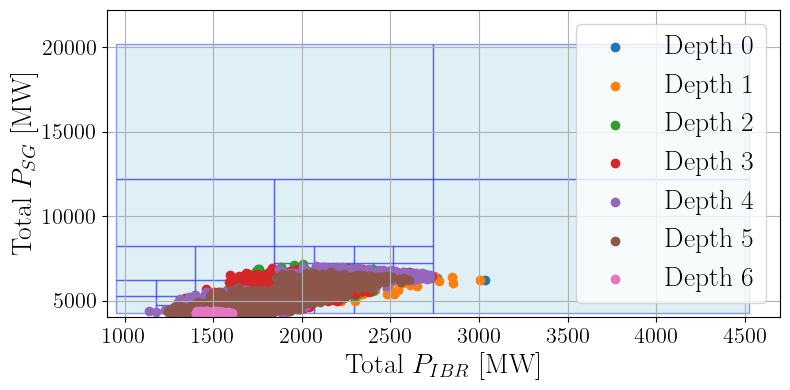

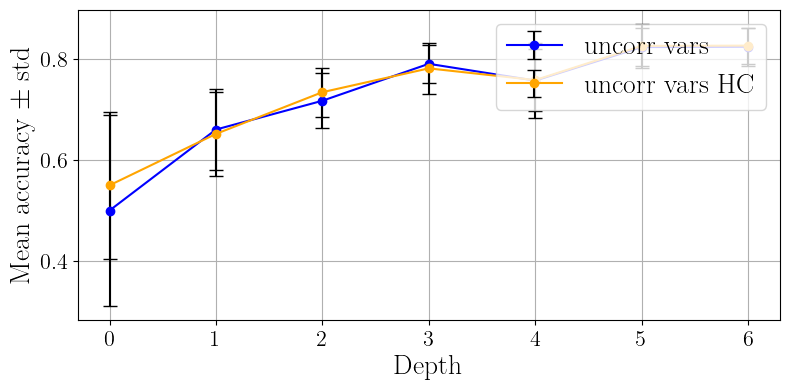

In [28]:
cases_id_depth = pd.read_excel('cases_id_depth.xlsx')[['Depth','case_id','CellName']]
cases_id_depth_feas = cases_id_depth.query('case_id == @case_id_feasible')


scores_df_uncorr = kfold_cv_depth(results_dataframes, 'uncorr', dimensions_caseid_feasible, cases_id_depth_feas, plot_depth_exploration=True, n_fold=5)
scores_df_uncorr_HierCl = kfold_cv_depth(results_dataframes, 'uncorr_HierCl', dimensions_caseid_feasible, cases_id_depth_feas, plot_depth_exploration=True, n_fold=5)

pd.DataFrame.to_excel(scores_df_uncorr,'scores_df_uncorr_xgb.xlsx')
pd.DataFrame.to_excel(scores_df_uncorr_HierCl,'scores_df_uncorr_HierCl_xgb.xlsx')
    
#%%
fig, ax = plt.subplots()
ax.errorbar(scores_df_uncorr['Depth'], scores_df_uncorr['score_mean'], yerr=scores_df_uncorr['score_std'], fmt='-o', capsize=5, color='blue', ecolor='black', elinewidth=1.5, label = 'uncorr vars')
ax.errorbar(scores_df_uncorr_HierCl['Depth'], scores_df_uncorr_HierCl['score_mean'], yerr=scores_df_uncorr_HierCl['score_std'], fmt='-o', capsize=5, color='orange', ecolor='black', elinewidth=1.5, label = 'uncorr vars HC')
ax.set_xlabel('Depth')
ax.set_ylabel('Mean accuracy $\pm$ std')
ax.grid()
plt.legend()
fig.tight_layout()
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.pdf')#, format='pdf')
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.png')#, format='png')

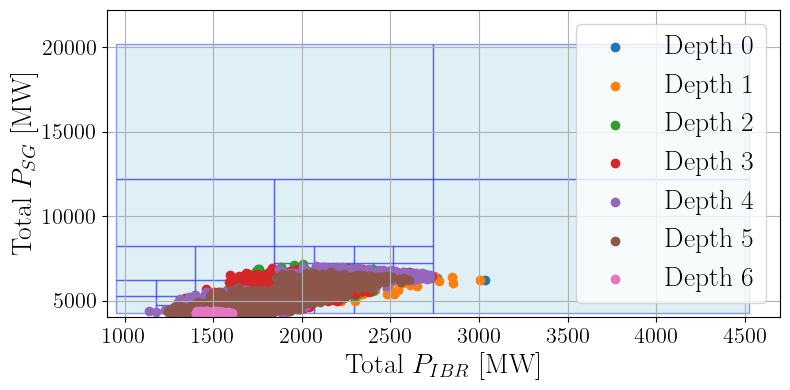

In [29]:
#check if the taus variables add noise or not:

results_dataframes['case_df_op_feasible_uncorr_HierCl_notaus'] = results_dataframes['case_df_op_feasible_uncorr_HierCl'].drop(df_taus.columns, axis=1)
scores_df_uncorr_HC_notau = kfold_cv_depth(results_dataframes, 'uncorr_HierCl_notaus', dimensions_caseid_feasible, cases_id_depth_feas, plot_depth_exploration=True, n_fold=5)

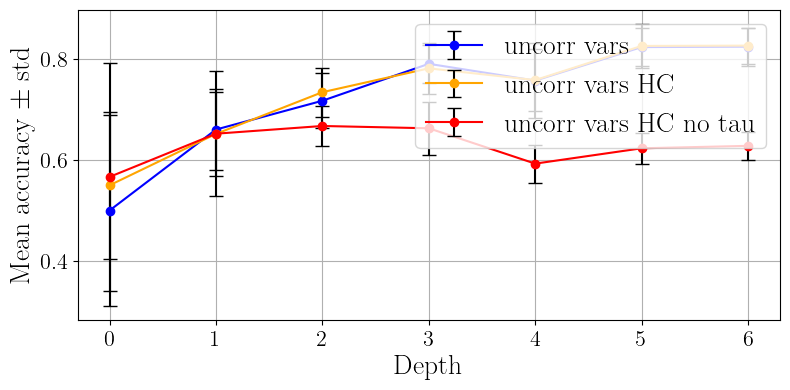

In [30]:
fig, ax = plt.subplots()
ax.errorbar(scores_df_uncorr['Depth'], scores_df_uncorr['score_mean'], yerr=scores_df_uncorr['score_std'], fmt='-o', capsize=5, color='blue', ecolor='black', elinewidth=1.5, label = 'uncorr vars')
ax.errorbar(scores_df_uncorr_HierCl['Depth'], scores_df_uncorr_HierCl['score_mean'], yerr=scores_df_uncorr_HierCl['score_std'], fmt='-o', capsize=5, color='orange', ecolor='black', elinewidth=1.5, label = 'uncorr vars HC')
ax.errorbar(scores_df_uncorr_HC_notau['Depth'], scores_df_uncorr_HC_notau['score_mean'], yerr=scores_df_uncorr_HC_notau['score_std'], fmt='-o', capsize=5, color='red', ecolor='black', elinewidth=1.5, label = 'uncorr vars HC no tau')
ax.set_xlabel('Depth')
ax.set_ylabel('Mean accuracy $\pm$ std')
ax.grid()
plt.legend()
fig.tight_layout()
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.pdf')#, format='pdf')
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.png')#, format='png')

## Principal Component Analysis and Manifolds

In [66]:
def PCA_Mani(df_scaled, model = PCA()):
    X_PCA = model.fit_transform(df_scaled)
    cumulative_variance = None
    if isinstance(model, PCA):
        explained_variance = model.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
    
        fig = plt.figure()
        ax = fig.add_subplot()
        # ax.bar(range(1, len(explained_variance)+1), explained_variance,
        ax.scatter(range(1, len(explained_variance)+1), explained_variance)#,
               #alpha=0.5, align='center', label='Individual explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.tick_params(axis='x')
        plt.tick_params(axis='y')
        # ax.set_xlim(0,20)
        # ax.set_xticks([1,2,3])
        # ax.set_xticklabels(['$X_A$','$X_B$','$X_C$'])
        plt.tight_layout()
        
        plt.figure()
        plt.plot(range(1, len(cumulative_variance) + 1),
                 cumulative_variance, marker='o', linestyle='--')
        plt.title('Cumulative Explained Variance by Number of Dimensions')
        plt.xlabel('Number of Dimensions')
        plt.ylabel('Cumulative Explained Variance')
        plt.xlim(1, len(cumulative_variance))
        plt.ylim(0, 1)
        plt.grid()
        plt.axhline(y=0.95, color='r', linestyle='--',
                    label='95% Variance Threshold')  # Optional threshold line
        plt.legend()
        plt.show()
    return X_PCA, cumulative_variance


def plot_3d(pca_result, stab, elev=20, azim=45):
    # Create 3D figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot for each stab group
    ax.scatter(pca_result[stab == 0, 0], pca_result[stab == 0, 1], pca_result[stab == 0, 2],
               c='red', label='stab=0', alpha=0.7, s=50)
    
    ax.scatter(pca_result[stab == 1, 0], pca_result[stab == 1, 1], pca_result[stab == 1, 2],
               c='green', label='stab=1', alpha=0.7, s=50)
    
    # Labels
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Legend
    ax.legend()
    ax.view_init(elev=elev, azim=azim)    
    plt.title('3D PCA Scatter Plot with stab colors')
    plt.show()

def pca_plot(n_components, pca_result, stab): 
    colors = np.where(stab == 1, 'green', 'red')

    fig, axes = plt.subplots(n_components, n_components, figsize=(3*n_components, 3*n_components))
    
    for i in range(n_components):
        for j in range(n_components):
            ax = axes[i, j]
            if i == j:
                # Histogram on the diagonal (split by stab)
                ax.hist(pca_result[stab == 0, i], bins=20, color='red', alpha=0.5, label='stab=0')
                ax.hist(pca_result[stab == 1, i], bins=20, color='green', alpha=0.5, label='stab=1')
                if j == 0:  # Add legend only once
                    ax.legend()
            else:
                # Scatter plot with color based on stab
                ax.scatter(pca_result[stab == 0, j], pca_result[stab == 0, i], color='red', alpha=0.6, s=10)
                ax.scatter(pca_result[stab == 1, j], pca_result[stab == 1, i], color='green', alpha=0.6, s=10)
            
            # Clean ticks
            if i < n_components - 1:
                ax.set_xticks([])
            if j > 0:
                ax.set_yticks([])
    
            # Axis labels
            if j == 0:
                ax.set_ylabel(f'PC{i+1}')
            if i == n_components - 1:
                ax.set_xlabel(f'PC{j+1}')
    
    plt.tight_layout()
    plt.show()


In [32]:
# %% ---- SCALE DATA ----

scaler1 = StandardScaler() 
df_scaled_StdSc = scaler1.fit_transform(results_dataframes['case_df_op_feasible'].drop(['case_id','Stability'],axis=1).reset_index(drop=True))

scaler2 = MinMaxScaler() 
df_scaled_MinMax = scaler2.fit_transform(results_dataframes['case_df_op_feasible'].drop(['case_id','Stability'],axis=1).reset_index(drop=True))


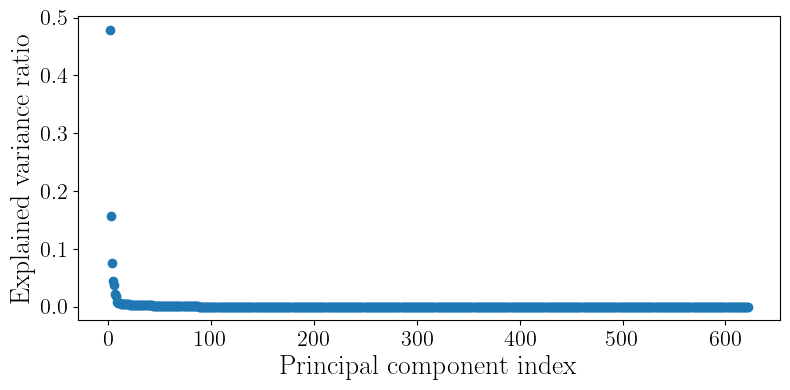

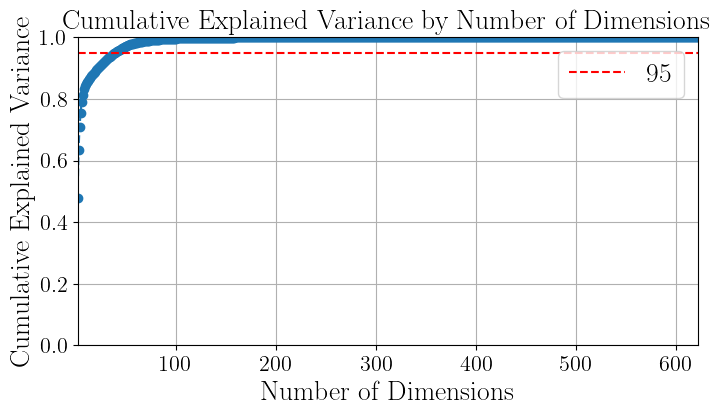

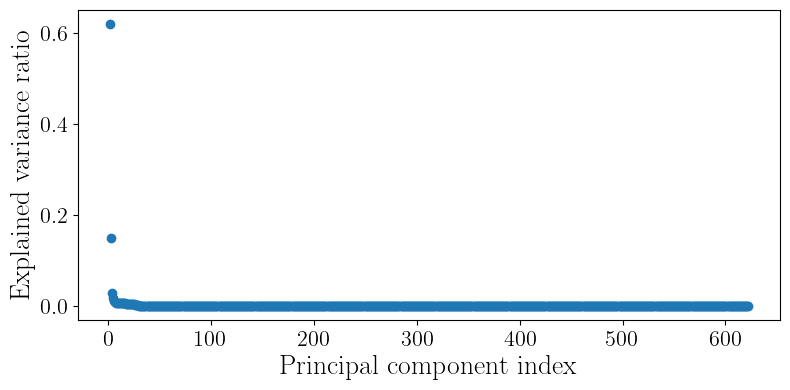

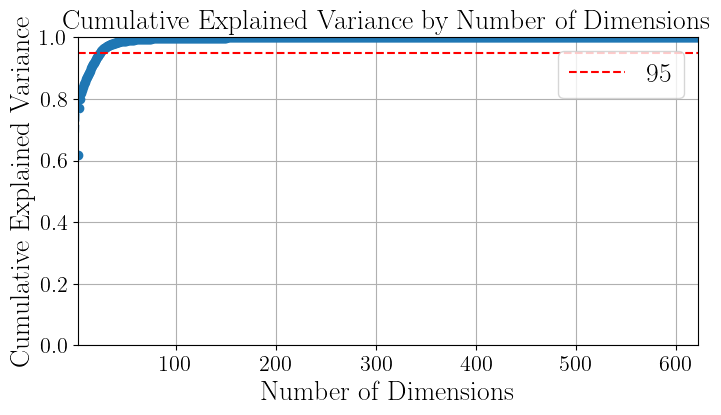

In [39]:
X_PCA_StdSc, cumulative_variance = PCA_Mani(df_scaled_StdSc, PCA())
X_PCA_MinMax, cumulative_variance= PCA_Mani(df_scaled_MinMax, PCA())

C:\Users\Francesca\miniconda3\envs\hp2c-dt\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Francesca\miniconda3\envs\hp2c-dt\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Francesca\miniconda3\envs\hp2c-dt\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
C:\Users\Francesca\miniconda3\envs\hp2c-dt\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\Francesca\miniconda3\envs\hp2c-dt\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\Francesca\miniconda

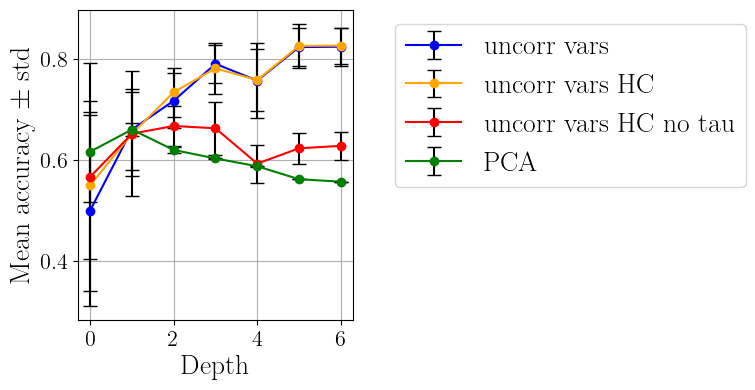

In [40]:
index = np.argmax(cumulative_variance > 0.95) if np.any(cumulative_variance > 0.95) else -1
results_dataframes['case_df_op_feasible_PCA'] = pd.concat([pd.DataFrame(X_PCA_StdSc[:,0:index]),results_dataframes['case_df_op_feasible'][['case_id','Stability']]],axis=1)
scores_df_PCA = kfold_cv_depth(results_dataframes, 'PCA', dimensions_caseid_feasible, cases_id_depth_feas, plot_depth_exploration=False, n_fold=5)

fig, ax = plt.subplots()
ax.errorbar(scores_df_uncorr['Depth'], scores_df_uncorr['score_mean'], yerr=scores_df_uncorr['score_std'], fmt='-o', capsize=5, color='blue', ecolor='black', elinewidth=1.5, label = 'uncorr vars')
ax.errorbar(scores_df_uncorr_HierCl['Depth'], scores_df_uncorr_HierCl['score_mean'], yerr=scores_df_uncorr_HierCl['score_std'], fmt='-o', capsize=5, color='orange', ecolor='black', elinewidth=1.5, label = 'uncorr vars HC')
ax.errorbar(scores_df_uncorr_HC_notau['Depth'], scores_df_uncorr_HC_notau['score_mean'], yerr=scores_df_uncorr_HC_notau['score_std'], fmt='-o', capsize=5, color='red', ecolor='black', elinewidth=1.5, label = 'uncorr vars HC no tau')
ax.errorbar(scores_df_PCA['Depth'], scores_df_PCA['score_mean'], yerr=scores_df_PCA['score_std'], fmt='-o', capsize=5, color='green', ecolor='black', elinewidth=1.5, label = 'PCA')
ax.set_xlabel('Depth')
ax.set_ylabel('Mean accuracy $\pm$ std')
ax.grid()
ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left')
#plt.legend()
fig.tight_layout()
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.pdf')#, format='pdf')
#plt.savefig('scores_vs_depth__df_uncorr_var_HierCl_xgb.png')#, format='png')

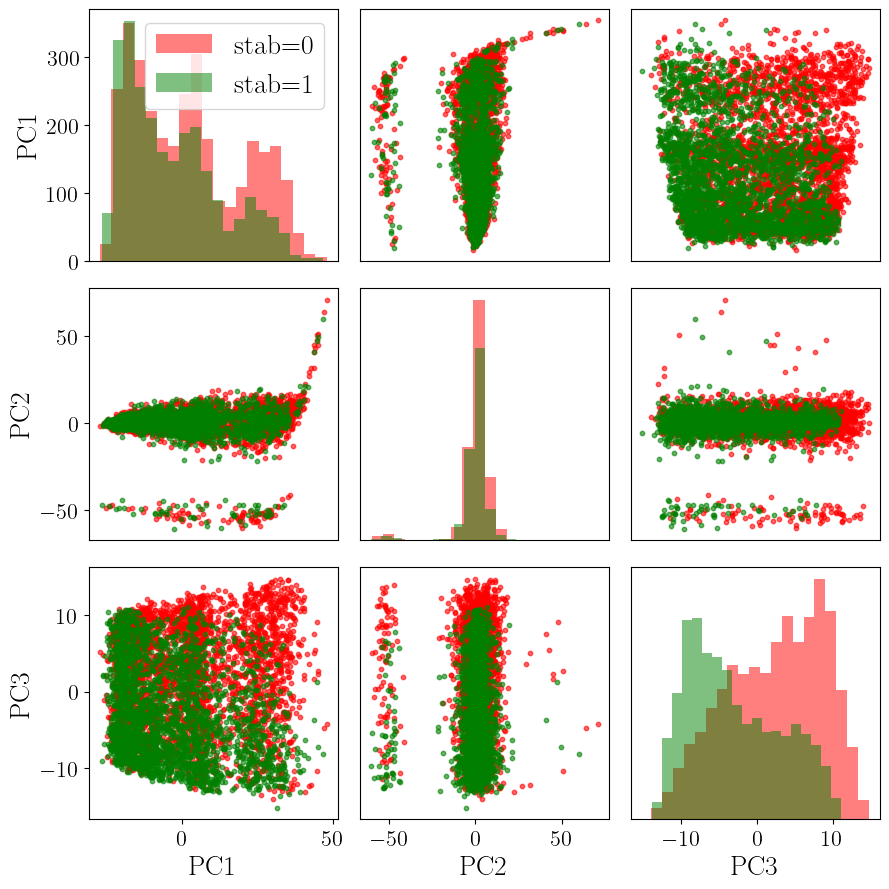

In [42]:
stability = np.array(results_dataframes['case_df_op_feasible'][['Stability']]).ravel()
pca_plot(3, X_PCA_StdSc, stability)

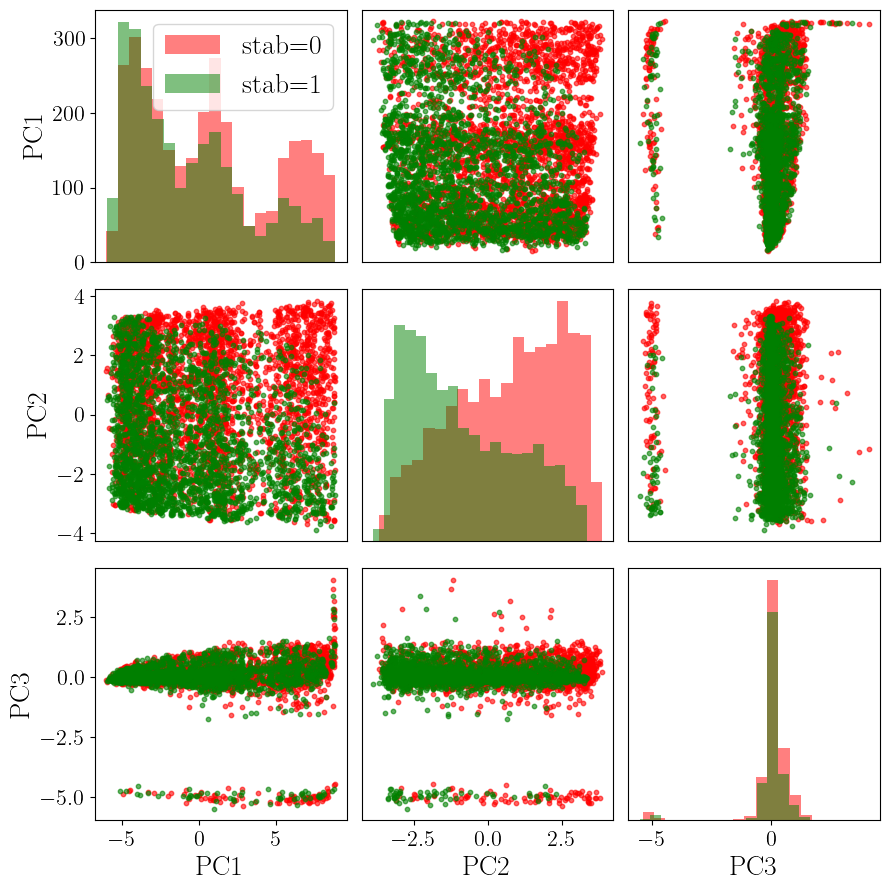

In [49]:
pca_plot(3, X_PCA_MinMax, stability)

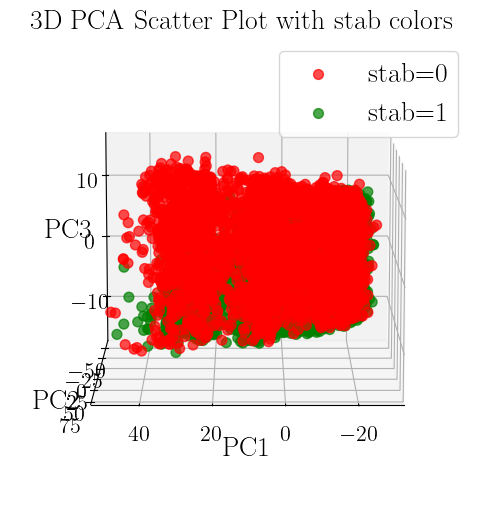

In [62]:
plot_3d(X_PCA_StdSc, stability, 10, 90)


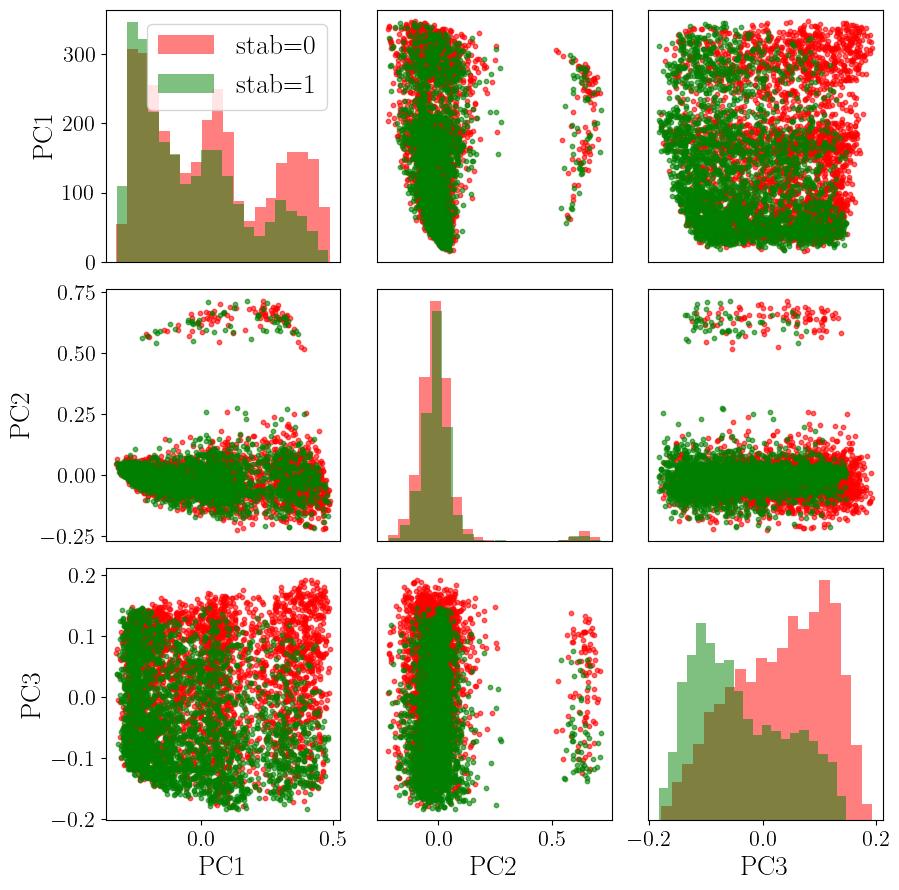

In [79]:
from sklearn.decomposition import KernelPCA

kernel_pca = KernelPCA(n_components=3, kernel="rbf", gamma=0.0001, fit_inverse_transform=True, alpha=0.1)
# proj = kernel_pca.fit_transform(array_2d_red)
# proj.shape
X_kPCA_StdSc, _ = PCA_Mani(df_scaled_StdSc, kernel_pca)
pca_plot(3, X_kPCA_StdSc, stability)

## Convex Hull

In [78]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
hull = ConvexHull(X_PCA_StdSc[:,[0,2]])

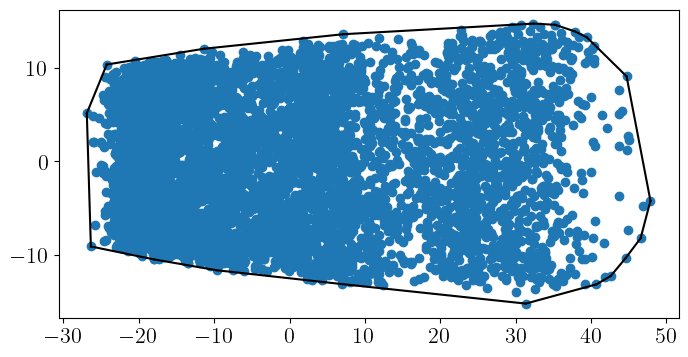

In [47]:
plt.plot(X_PCA_StdSc[:,0], X_PCA_StdSc[:,2], 'o')
for simplex in hull.simplices:
    plt.plot(X_PCA_StdSc[simplex, 0], X_PCA_StdSc[simplex, 2], 'k-')